# Geochem for Machine Learning: Preprocessing and a Simple Classification Example

In this notebook we'll provide a simple example of preprocessing some geochemical data for use in a classificaiton workflow. We'll also look at how this contrasts to more traditional methods of classification within geochemistry, and how programmatic workflows and tools can not only make this more robust, but also more reproducible. This exercise is adapted somewhat from earlier examples of the first author, here with a slightly different focus. The principal role of `pyrolite` in this example is for getting data in shape such that it's ready to be input into a machine learning workflow/pipeline (largely facilitated by [`scikit-learn`](https://scikit-learn.org/)), but we can also examine how a data-driven programmatic approach provides a number of advantages over other traditional methods - including reproducibility.


## Traditional Classification Methods in Geochemistry

In geochemistry, classification is for historical reasons often treated as a graphical or two-dimensional problem for which the output includes a graphically-represented classification or discrimination diagram (driven by a need to visualize the data; e.g. [Pearce, 1973]; [Le Bas et al. 1992] ). And while many of these diagrams have been practically useful for 'binning' and describing rocks, the divisions we use don't necessarily make sense in the natural world (e.g. consider the Total Alkali - Silica diagram). Modern statistical and machine learning techniques can readily be applied to make better use of the data dimensionality and move beyond the human-centric limitations. In this case a data driven approach instead considers divisions according to the natural clustering of data, where they exist.

## Towards Multivariate Machine Classification

Below we'll demonstrate a machine learning approach to classifying basalt geochemistry based on tectonic setting. We'll adapt a version of a support vector classifier, similar to those previously used for this problem ([Petrelli, 2016]; [Ueki, 2018]), and re-use the same 29-dimension tectonic discrimination dataset (just over 2000 samples taken from global repositories, each with majors, minors, traces and isotopes) from Ueki et al. (2018), modified to record the tectonic setting of each basalt in a 'Class' column.

First let's examine a well-used trace element discrimination diagram (the Th-Nb-Yb diagram; [Pearce, 2008]) to get some insight what some of the key issues with classification using only a few elements or dimension. This is one of number of classification and tectonic diagrams have been developed which use specific geochemical proxies to link rock and mineral geochemistry to geological processes and reservoirs (here Nb/Yb and Th/Yb which distinguish relative enrichment of the mantle and arc-related processes). As the diagram presents only two dimensions (or three, depending who you talk to), the data presented show only part of the whole picture. This reduced dimensionality means that when you compare rocks from a variety of settings, you're likely to see large degrees of overlap, as found by [Li et al. (2015)], and shown below. While the diagram is not particularly useful as a classification tool, the proxies used (ratios or otherwise) still provide useful 'features' which can be added to datasets before constructing a multivariate classifier.

| <img src="https://github.com/morganjwilliams/gs2020-diggingdeeper/raw/develop/img/Smithies2018Fig1.png" style="display:inline; margin: 0px 15px 15px 0px;" width="70%"/>|<img src="https://github.com/morganjwilliams/gs2020-diggingdeeper/raw/develop/img/Li2015Fig9.png" style="display:inline; margin: 0px 15px 15px 0px;" width="70%"/> |
|--|--|
| Figure from [Smithies (2018)] illustrating the main features of the Th-Yb-Nb diagram [Pearce (2008)], including the mantle or 'MORB-OIB array' and the 'modern arc array'. | Figure from [Li et al. (2015)], illustrating the significant degree of overlap in these two dimensions between different tectonic settings renders this approach futile for generalized discrimination.  |

<!--(BAB: Back Arc Basin, CA: Continental Arc, CFB: Continental Flood Basalt, IA: Island Arc, IOA: Intra-oceanic Arc, MOR: Mid-Ocean Ridge, OI: Ocean Island, OP: Oceanic Plateau) -->

[Pearce, 1973]: https://doi.org/10.1016/0012-821X(73)90129-5 "Pearce, J.A., Cann, J.R., 1973. Tectonic setting of basic volcanic rocks determined using trace element analyses. Earth and Planetary Science Letters 19, 290–300. doi: 10.1016/0012-821X(73)90129-5"

[Li et al. (2015)]: https://doi.org/10.1016/j.lithos.2015.06.022 "Li, C., Arndt, N.T., Tang, Q., Ripley, E.M., 2015. Trace element indiscrimination diagrams. Lithos 232, 76–83. "

[Le Bas et al. 1992]: https://doi.org/10.1007/BF01160698 "Le Bas M. J., Le Maitre R. W. and Woolley A. R., 1992. The construction of the Total Alkali-Silica chemical classification of volcanic rocks. Mineral. Petrol. 46, 1–22."

[Smithies (2018)]: https://doi.org/10.1016/j.epsl.2018.01.034 "Smithies, R.H., Ivanic, T.J., Lowrey, J.R., Morris, P.A., Barnes, S.J., Wyche, S., Lu, Y.-J., 2018. Two distinct origins for Archean greenstone belts. Earth and Planetary Science Letters 487, 106–116."

[Pearce (2008)]: https://doi.org/10.1016/j.lithos.2007.06.016 "Pearce, J.A., 2008. Geochemical fingerprinting of oceanic basalts with applications to ophiolite classification and the search for Archean oceanic crust. Lithos 100, 14–48."

[Pearce, 2008]: https://doi.org/10.1016/j.lithos.2007.06.016 "Pearce, J.A., 2008. Geochemical fingerprinting of oceanic basalts with applications to ophiolite classification and the search for Archean oceanic crust. Lithos 100, 14–48."

[Petrelli, 2016]: https://doi.org/10.1007/s00410-016-1292-2 "Petrelli, M., Perugini, D., 2016. Solving petrological problems through machine learning: the study case of tectonic discrimination using geochemical and isotopic data. Contrib Mineral Petrol 171, 81."

[Ueki, 2018]: https://doi.org/10.1029/2017GC007401 "Ueki, K., Hino, H., Kuwatani, T., 2018. Geochemical Discrimination and Characteristics of Magmatic Tectonic Settings: A Machine-Learning-Based Approach. Geochemistry, Geophysics, Geosystems 19, 1327–1347."

## Dataset and Preprocessing

Here we go through a few simple preprocessing steps to get the dataset ready for input into our pipeline. For more on preprocessing (especially if you don't start from a nice data table like this one), [see the first example notebook on 'munging'](./01_munging.ipynb)

In [1]:
import pandas as pd
import numpy as np
import pyrolite.geochem
from util import get_onedrive_directlink

ueki_2018_dataset_url = get_onedrive_directlink("https://1drv.ms/u/s!As2ibEui13xmkqQLTMPI4hn4ACEc_w?e=cmcqU8")

In [2]:
df = pd.read_csv(ueki_2018_dataset_url)
df.head()

,Cluster_ID,Number,SiO2,TiO2,Al2O3,Fe2O3,MgO,CaO,Na2O,K2O,...,Lu,Ba,Hf,Nb,Rb,Sr,Ta,Th,Y,Zr
0,1,And1,50.755719,1.582925,15.114379,9.426062,8.843954,9.354575,3.053513,1.868873,...,0.30,609.0,4.1,31.0,39.0,911.0,2.0,8.3,25.0,185.0
1,1,And2,65.344932,0.799110,15.779891,4.491200,2.205139,4.127048,3.944973,3.307708,...,0.12,655.0,4.0,12.0,132.0,421.0,0.9,16.2,13.0,183.0
2,1,And3,64.282845,0.873845,15.970269,4.881479,2.480916,4.339092,4.037766,3.133789,...,0.11,798.0,5.6,11.0,113.0,525.0,0.8,14.1,12.0,236.0
3,1,And4,61.421320,1.015228,15.939086,6.335025,3.360406,5.431472,3.695431,2.802030,...,0.18,717.0,4.1,20.0,77.0,533.0,1.6,12.0,19.0,217.0
4,1,And5,59.801663,1.131924,15.927076,6.631273,4.137033,5.779826,4.086948,2.504257,...,0.14,664.0,5.4,14.0,78.0,607.0,1.5,11.2,15.0,233.0


In [3]:
df.columns

Index(['Cluster_ID', 'Number', 'SiO2', 'TiO2', 'Al2O3', 'Fe2O3', 'MgO', 'CaO',
       'Na2O', 'K2O', 'SR87_SR86', 'Nd143_Nd144', 'Pb206_Pb204', 'Pb207_Pb204',
       'Pb208_Pb204', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Yb', 'Lu', 'Ba', 'Hf',
       'Nb', 'Rb', 'Sr', 'Ta', 'Th', 'Y', 'Zr'],
      dtype='object')

First we, can make sure that our different tectonic settings are represented in a readable way. Here we change `Cluster_ID` to contain an abbrevaition of the class name (BAB: Back Arc Basin, CA: Continental Arc, CFB: Continental Flood Basalt, IA: Island Arc, IOA: Intra-oceanic Arc, MOR: Mid-Ocean Ridge, OI: Ocean Island, OP: Oceanic Plateau):

In [4]:
classes = ["CA", "IA", "IOA", "BAB", "CFB", "MOR", "OP", "OI"]
class_converter = {ix + 1: classes[ix] for ix in range(len(classes))}
df["Cluster_ID"] = df["Cluster_ID"].apply(lambda x: class_converter[x])

In [5]:
df.pyrochem.add_ratio("Th/Yb")
df.pyrochem.add_ratio("Nb/Yb");

In [6]:
df.head()

,Cluster_ID,Number,SiO2,TiO2,Al2O3,Fe2O3,MgO,CaO,Na2O,K2O,...,Hf,Nb,Rb,Sr,Ta,Th,Y,Zr,Th/Yb,Nb/Yb
0,CA,And1,50.755719,1.582925,15.114379,9.426062,8.843954,9.354575,3.053513,1.868873,...,4.1,31.0,39.0,911.0,2.0,8.3,25.0,185.0,4.150000,15.500000
1,CA,And2,65.344932,0.799110,15.779891,4.491200,2.205139,4.127048,3.944973,3.307708,...,4.0,12.0,132.0,421.0,0.9,16.2,13.0,183.0,19.756098,14.634146
2,CA,And3,64.282845,0.873845,15.970269,4.881479,2.480916,4.339092,4.037766,3.133789,...,5.6,11.0,113.0,525.0,0.8,14.1,12.0,236.0,17.848101,13.924051
3,CA,And4,61.421320,1.015228,15.939086,6.335025,3.360406,5.431472,3.695431,2.802030,...,4.1,20.0,77.0,533.0,1.6,12.0,19.0,217.0,9.022556,15.037594
4,CA,And5,59.801663,1.131924,15.927076,6.631273,4.137033,5.779826,4.086948,2.504257,...,5.4,14.0,78.0,607.0,1.5,11.2,15.0,233.0,11.666667,14.583333


In [7]:
compositional_variables = df.pyrochem.list_compositional 
abundances = [i for i in df.columns if i in compositional_variables]
isotopes = [i for i in df.columns if i not in ["Cluster_ID", 'Number'] and i not in compositional_variables]
 
classes = list(df.Cluster_ID.unique())

## A Simple Classifier

For sake of illustration, we can build a simple classifier here and see what the minimum steps required to have a working model look like:

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

First we need to decide what we wish to predict - in this case we want to predict the `Cluster_ID` using the element and oxide abundances together with the isotope ratios:

In [9]:
X, y = df.loc[:, abundances + isotopes], df["Cluster_ID"]

From this we can create some independent training and test sets so we can more accurately asses the performance of the model we're about to create and make sure our model is more generalisable:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y, 
                                                    test_size=0.3)

Rather than use the data as-is, we should first scale it so that it's within the range which our classifier model is optimised for (typically -1 to 1 or so). Here we can use a standard scaler which normalises each of our variables to their respective mean and standard deviations. We can combine this with a classifier model and construct a pipeline. Here we've used a support vector classifier model (SVC), which should deal with our relatively limited dataset more readily than more complex models might:

In [11]:
svc_pipeline = make_pipeline(StandardScaler(), SVC())
svc_pipeline

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

We can now fit our simple classifer model, with the training data:

In [12]:
svc_pipeline.fit(X_train, y_train);

We can quickly check how well this classifier performs overall by seeing what percentage of our testing data it accurately classifies:

In [13]:
svcscore = svc_pipeline.score(X_test, y_test)
"Overall Accuracy: {:.1f}%".format(svcscore*100)

'Overall Accuracy: 85.7%'

That's not bad for a few lines of code and a fairly small dataset!

## Adding Some Detail

We can improve on this simple model by adding in a few extra steps, parameters and details. Here we create a probabilistic equivalent of our SVC model, and independently process our abudnance and isotopic data to account for their naturally non-normal distributions. Additionally, we build a number of different models and choose the best of the bunch. First we'll build a pipeline, then put this within a grid search cross-validation optimizer which will search across a grid of specified parameter ranges to find a more optimal model.

In [14]:
from sklearn.compose import ColumnTransformer
from pyrolite.util.skl.transform import CLRTransform, LogTransform

# transform the abudnances and isotope ratios differently - accounting for their compositional and log-normal distributions, repsectively
transform = ColumnTransformer([("abundances", CLRTransform(), abundances), ("isotopes", LogTransform(), isotopes)])

# make a scaler, as before
scaler = StandardScaler()

# build a one-versus-others radial basis function SVC which is calibrated for probabilistic output, and balances performance across classes
clf = SVC(kernel="rbf", decision_function_shape="ovo", probability=True, class_weight="balanced")

# put these together in a pipeline
pipeline = make_pipeline(transform, scaler, clf)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('abundances', CLRTransform(),
                                                  ['SiO2', 'TiO2', 'Al2O3',
                                                   'Fe2O3', 'MgO', 'CaO',
                                                   'Na2O', 'K2O', 'La', 'Ce',
                                                   'Nd', 'Sm', 'Gd', 'Yb', 'Lu',
                                                   'Ba', 'Hf', 'Nb', 'Rb', 'Sr',
                                                   'Ta', 'Th', 'Y', 'Zr']),
                                                 ('isotopes', LogTransform(),
                                                  ['SR87_SR86', 'Nd143_Nd144',
                                                   'Pb206_Pb204', 'Pb207_Pb204',
                                                   'Pb208_Pb204', 'Th/Yb',
                                                   'Nb/Yb'])])),
                ('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', decision_function_shape='ovo',
                     probability=True))])

Now we can put this in our gridsearch:

In [15]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
param_grid = dict(svc__gamma=np.logspace(-2.3, -0.85, 8), svc__C=np.logspace(-0.5, 2.5, 8)) # limit C parameter to avoid overfitting   
gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(n_splits=6, shuffle=True), n_jobs=4, verbose=3)
gs

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('abundances',
                                                                         CLRTransform(),
                                                                         ['SiO2',
                                                                          'TiO2',
                                                                          'Al2O3',
                                                                          'Fe2O3',
                                                                          'MgO',
                                                                          'CaO',
                                                                          'Na2O',
                                                                          'K2O',
                                                                          'La',
                                                                          'Ce',
                                                                          'Nd',
                                                                          'Sm',
                                                                          'Gd',
                                                                          'Yb',
                                                                          'Lu',
                                                                          'Ba',
                                                                          'Hf',
                                                                          'Nb',
                                                                          'Rb',
                                                                          'Sr',
                                                                          'Ta',
                                                                          'Th',
                                                                          'Y',
                                                                          'Zr']),
                                                                        ('isotopes',
                                                                         LogTransform(),
                                                                         ['S...
                                        SVC(class_weight='balanced',
                                            decision_function_shape='ovo',
                                            probability=True))]),
             n_jobs=4,
             param_grid={'svc__C': array([3.16227766e-01, 8.48342898e-01, 2.27584593e+00, 6.10540230e+00,
       1.63789371e+01, 4.39397056e+01, 1.17876863e+02, 3.16227766e+02]),
                         'svc__gamma': array([0.00501187, 0.00807501, 0.01301025, 0.0209618 , 0.03377314,
       0.05441446, 0.08767124, 0.14125375])},
             verbose=3)

From here we'll train the various models over the parameter grid (building 64 different models, each 6 times):

In [16]:
gs.fit(X_train, y_train)

Fitting 6 folds for each of 64 candidates, totalling 384 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   30.8s
[Parallel(n_jobs=4)]: Done 384 out of 384 | elapsed:   39.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('abundances',
                                                                         CLRTransform(),
                                                                         ['SiO2',
                                                                          'TiO2',
                                                                          'Al2O3',
                                                                          'Fe2O3',
                                                                          'MgO',
                                                                          'CaO',
                                                                          'Na2O',
                                                                          'K2O',
                                                                          'La',
                                                                          'Ce',
                                                                          'Nd',
                                                                          'Sm',
                                                                          'Gd',
                                                                          'Yb',
                                                                          'Lu',
                                                                          'Ba',
                                                                          'Hf',
                                                                          'Nb',
                                                                          'Rb',
                                                                          'Sr',
                                                                          'Ta',
                                                                          'Th',
                                                                          'Y',
                                                                          'Zr']),
                                                                        ('isotopes',
                                                                         LogTransform(),
                                                                         ['S...
                                        SVC(class_weight='balanced',
                                            decision_function_shape='ovo',
                                            probability=True))]),
             n_jobs=4,
             param_grid={'svc__C': array([3.16227766e-01, 8.48342898e-01, 2.27584593e+00, 6.10540230e+00,
       1.63789371e+01, 4.39397056e+01, 1.17876863e+02, 3.16227766e+02]),
                         'svc__gamma': array([0.00501187, 0.00807501, 0.01301025, 0.0209618 , 0.03377314,
       0.05441446, 0.08767124, 0.14125375])},
             verbose=3)

## How does our model perform?

We can see that our model peforms slightly better:

In [17]:
gridscore = gs.score(X_test, y_test)
"Overall Accuracy: {:.1f}%".format(gridscore*100)

'Overall Accuracy: 94.2%'

But more importantly, the model should be more generalizable, and should have more balanced performance across our classes. To look at this in a little more detail, we can examine the confusion matricies for each of our models - which examines how samples from the test set were predicted to fall, compared to their true classes. One thing to note here is that where samples are incorrectly classified, they tend to be incorrectly classified as from similar tecotnic settings. For example, back arc basin related samples are relatively commonly incorrectly classified as being form island arcs, intra-oceanic arcs and mid ocean ridges; all of these have geological and geochemical similarities to the back arc basin samples.

Text(0.5, 1.0, 'Customised Pipeline')

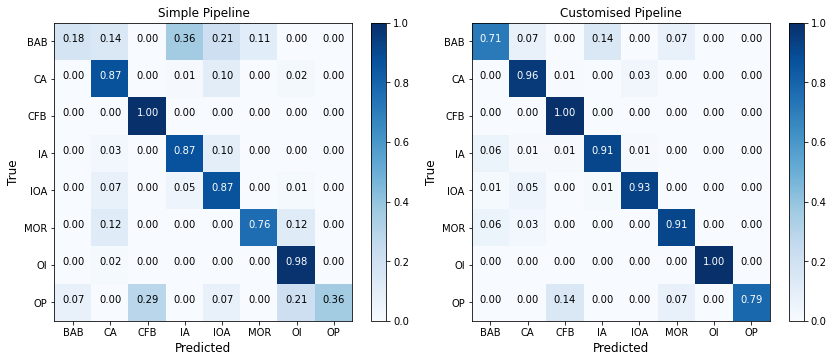

In [18]:
import matplotlib.pyplot as plt
from pyrolite.util.skl.vis import plot_confusion_matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_confusion_matrix(svc_pipeline, X_test, y_test, normalize=True, ax=ax[0])
plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize=True, ax=ax[1])

ax[0].set_title('Simple Pipeline')
ax[1].set_title('Customised Pipeline')

## How does this compare to a graphical classification equivalent?

Revisiting the original scenario we described above, we can examine how our classifier does compared to e.g. the Pearce Th-Nb-Yb diagram at discriminating tectonic settings:

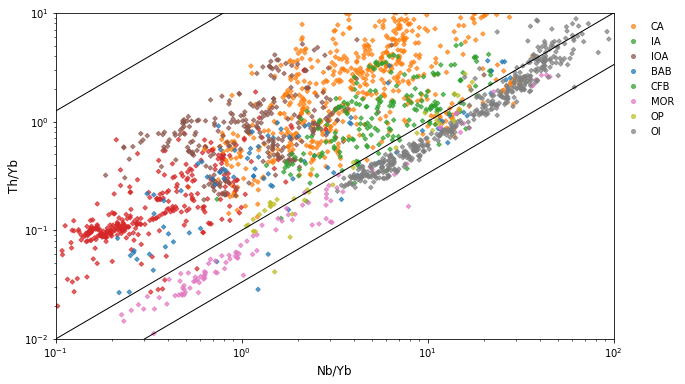

In [19]:
from pyrolite.plot.color import process_color
from pyrolite.plot.templates import pearceThNbYb
from pyrolite.util.plot.legend import proxy_line

fig, ax = plt.subplots(1, figsize=(10, 6))
pearceThNbYb(ax)

colors = process_color(gs.best_estimator_.predict(X.loc[:, abundances + isotopes]), cmap='tab10', alpha=0.8)['c']

for ID in df.Cluster_ID.unique():
    subdf = df.loc[df.Cluster_ID==ID, :]
    subdf[['Nb/Yb', 'Th/Yb']].pyroplot.scatter(c=colors[df.Cluster_ID==ID], ax=ax, s=10, alpha=0.7)
    
ax.legend([proxy_line(c=coll.get_facecolors()[0], marker='o', ls='none') for coll in ax.collections],
          df.Cluster_ID.unique(),
          frameon=False,
          facecolor=None)
plt.show()

## Probabilistic Outputs

As we briefly mentioned above, we've used a probabilisitic version of a SVC model (calibrated using Platt scaling) to provide some probabilstic classificaiton outputs. We can examine what these look like for a selection of samples from the independed test set compared to their true tectonic settings.

In [20]:
samples = np.random.choice(np.arange(X_test.shape[0]), 8, replace=False)
probs = (
    pd.DataFrame(
        data=gs.best_estimator_.predict_proba(X_test.iloc[samples]),
        columns=gs.best_estimator_.classes_,
    )
    * 100
)
probs["True Tectonic Setting"] = y_test.iloc[samples].tolist()
table = probs[probs.columns[::-1]].round(2)
table.style.background_gradient(cmap="Blues", axis=1)

,True Tectonic Setting,OP,OI,MOR,IOA,IA,CFB,CA,BAB
0,IOA,0.010000,0.010000,0.010000,98.700000,0.600000,0.020000,0.290000,0.360000
1,CA,0.090000,0.080000,0.010000,0.080000,0.030000,0.030000,99.630000,0.060000
2,OI,0.040000,99.400000,0.080000,0.050000,0.030000,0.080000,0.310000,0.010000
3,OP,32.030000,26.590000,2.240000,6.530000,3.220000,19.950000,7.760000,1.680000
4,CFB,0.990000,0.460000,0.250000,0.770000,0.330000,95.890000,1.050000,0.260000
5,CA,0.030000,0.020000,0.030000,0.770000,1.280000,0.030000,97.740000,0.090000
6,OI,0.110000,95.790000,0.420000,0.260000,0.340000,2.330000,0.250000,0.500000
7,CA,0.010000,0.010000,0.010000,7.700000,0.640000,0.010000,91.170000,0.450000


While most of these are likely to be correctly classified - this provides some information which could be used to better understand the realistic performance of the model itself, as well as provide measures which can be linked to classificaiton uncertainty (get in touch if you want to know more on this front!).

## How can someone else use this on their own data?

While it's great to be able to build your own models, you'll likely eventually want to share your workflow and potentially the models themselves (perhaps even to put it into an app!). In the first instance, you could easily share and re-use this notebook with someone else - and that's a great first step! Beyond this, to make it reproducible, you should also provide some information to control the enviornment in which models are being built - like the versions of the packages you're using, system the models are build on, and the 'version' of the notebook which is used. Others could then re-train a model with your data, or create a new model using your workflow with their own data.

You can also save your models to disk and share them with others such that they can be loaded directly. For example, you can save either the model, pipeline or entire ensemble of models from our gridsearch:

In [21]:
import joblib

joblib.dump(gs._best_estimator, './pipeline.pkl') # just save the best pipeline
joblib.dump(gs, './gridsearch.pkl') # save all the pipelines

AttributeError: 'GridSearchCV' object has no attribute '_best_estimator'

And then load them back in:

In [ ]:
gs = joblib.load('./gridsearch.pkl')
estimator = joblib.load('./pipeline.pkl')

In [ ]:
estimator

The serialization of trained models and entire pipelines allows the models themselves (and the preprocessing steps) to be effectively reused.

## Beyond A Prototype

While we've put things togtether in a Jupyter notebook, eventually you might want to put this workflow together as a function which you might store in a separate `.py` file such that it can be imported and more easily referenced, versioned and adapted.